In [1]:
import pandas as pd
import numpy as np
import matplotlib as mlt
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import statsmodels.stats.power as smp
import scipy.stats
from scipy.stats import t, norm, ttest_ind, ttest_rel, ttest_1samp
import decimal
import random
%matplotlib inline

In [2]:
def conf_int_two_sample(x,y,alfa,alternative = 'two-tailed'):
    '''
    alternative == 'two-tailed','left','right'
    '''
    mean1 = np.mean(x)
    mean2 = np.mean(y)
    mean = mean1-mean2
    n1 = np.size(x)
    n2 = np.size(y)
    var1 = np.var(x,ddof=1)
    var2 = np.var(y,ddof=1)
    se = np.sqrt(var1/n1+var2/n2)
    if np.mean(x)-np.mean(y) >= 0:
        ts = (np.mean(x)-np.mean(y)-diff)/se
    else:
        ts = (np.mean(y)-np.mean(x)-diff)/se
    df = (var1/n1+var2/n2)**2/((var1/n1)**2/(n1-1)+(var2/n2)**2/(n2-1))
    #se = np.std(x,ddof=1)/np.sqrt(len(x))
    if alternative == 'two-tailed':
        return mean - t.ppf(1-alfa/2,df=df)*se,mean + t.ppf(1-alfa/2,df=df)*se
    elif alternative == 'left':
        return mean - t.ppf(1-alfa/2,df=df)*se
    elif alternative == 'right':
        return mean + t.ppf(1-alfa/2,df=df)*se

In [3]:
def get_normal_sample(n,mean,sd):
    return np.random.normal(loc=mean,scale=sd,size=n)

In [4]:
def t_test_for_independent_groups(x,y,diff = 0, alternative = 'two-tailed'): #Welch
    n1 = np.size(x)
    n2 = np.size(y)
    var1 = np.var(x,ddof=1)
    var2 = np.var(y,ddof=1)
    se = np.sqrt(var1/n1+var2/n2)
    ts = (np.mean(x)-np.mean(y)-diff)/se
    df = (var1/n1+var2/n2)**2/((var1/n1)**2/(n1-1)+(var2/n2)**2/(n2-1)) #Welch
    #if alternative == 'two-tailed':
    p_val = 2*t.sf(np.abs(ts),df)
    if alternative == 'two-tailed':
        p_val = 2*t.sf(np.abs(ts),df)
    if alternative == 'greater':
        p_val = t.sf(ts,df)
    if alternative == 'less':
        p_val = t.cdf(ts, df)
    return p_val

In [5]:
def independent_1(sample1,sample2,diff=0, eps = 0):
    mean1 = np.mean(sample1)
    mean2 = np.mean(sample2)
    mean = mean1-mean2
    
    if mean > diff+eps:
        return 'd'
    if  mean <= diff-eps:
        return 'm'
    if mean < delta+eps and mean > delta-eps  : #problematyczne eps > delta
        return 'nwd'


In [40]:
def independent_2(sample1, sample2, alfa, diff=0):
    mean = np.mean(sample1) - np.mean(sample2)
    #if mean >= 0:
    result = t_test_for_independent_groups(sample1,sample2,diff = 0, alternative = 'greater')
    #else:
    #    result = t_test_for_independent_groups(sample1,sample2,diff = 0, alternative = 'less')
    
    if result < alfa and np.abs(mean) > np.abs(diff):
        return 'd'
    elif result > alfa and (np.abs(mean) <= np.abs(diff)):
        return 'm'
    else:
        return 'nwd'    

In [43]:
def independent_3(sample1, sample2, alfa, diff=0):
    mean = np.mean(sample1) - np.mean(sample2)
    #if mean >= 0:
    result = t_test_for_independent_groups(sample1,sample2,diff = diff, alternative = 'greater')
    result2 = t_test_for_independent_groups(sample1,sample2,diff = diff,alternative='less')
    #else:
    #    result = t_test_for_independent_groups(sample1,sample2,diff = diff, alternative = 'less')
    #    result2 = t_test_for_independent_groups(sample1,sample2,diff = diff,alternative='greater')
    
    if result < alfa and np.abs(mean) > np.abs(diff):
        return 'd'
    elif (result2 < alfa) and (np.abs(mean) <= np.abs(diff)):
        return 'm'
    #if result >= alfa:
    else:
        return 'nwd'

In [8]:
duże1 = []
małe1 = []
duże2 = []
duże3 = []
małe2 = []
małe3 = []
źle_duże1 = []
niewiadomo_duże1 = []
źle_duże2 = []
niewiadomo_duże2 = []
źle_duże3 = []
niewiadomo_duże3 = []
źle_małe1 = []
niewiadomo_małe1 = []
źle_małe2 = []
niewiadomo_małe2 = []
źle_małe3 = []
niewiadomo_małe3 = []
przedziały_n = []
ile_dużych = []
ile_małych = []
means = []
delta = 1
mean = 0
eps = 1
sds = [i*0.1 for i in range(20,50)]
for k in range(1,25): 
    p1,p2 = 15+k*5,20+k*5
    for sd in sds:
        przedziały_n.append(p1)
        pod1 = []
        pod2 = []
        pod3 = []
        for n in range(p1,p2):
            for j in range(0,30):
                pop_mean = j*0.1
                alfa = 0.05
                sample1 = get_normal_sample(n,mean+pop_mean,sd)
                sample2 = get_normal_sample(n,mean,sd)
                pod1.append([independent_1(sample1,sample2,delta,eps),pop_mean,eps])
                pod2.append([independent_2(sample1,sample2,alfa,delta),pop_mean,alfa])
                pod3.append([independent_3(sample1,sample2,alfa,delta),pop_mean,alfa])
    
        # --------------------------------------------------      wśród wyników które były duże, ile z nich wskazał test - (wyniki wskazane przez test)/(faktycznie duże testy
        #---------------------------------------------------      ile razy test wskazał wynik mały, gdy ten w rzeczywistości był duży
        #---------------------------------------------------      ile razy test wskazał "nie wiadomo", gdy efekt w rzeczywistości był duży
        #podejście 1
        duże_pod1 = [i for i in pod1 if np.abs(i[1]) > np.abs(delta)]

        if len(duże_pod1) != 0:
            pod1_dobrze_duże = len([i for i in duże_pod1 if i[0] == 'd'])/len(duże_pod1)
            pod1_źle_duże = len([i for i in duże_pod1 if i[0] == 'm'])/len(duże_pod1)
            pod1_niewiadomo_duże = len([i for i in duże_pod1 if i[0] == 'nwd'])/len(duże_pod1)
        else:
            pod1_dobrze_duże = 'brak'
            pod1_źle_duże = 'brak'
            pod1_niewiadomo_duże = 'brak'
        #podejście 2
        duże_pod2 = [i for i in pod2 if np.abs(i[1]) > np.abs(delta)]
        if len(duże_pod2) != 0:
            pod2_dobrze_duże = len([i for i in duże_pod2 if i[0] == 'd'])/len(duże_pod2)
            pod2_źle_duże = len([i for i in duże_pod2 if i[0] == 'm'])/len(duże_pod2)
            pod2_niewiadomo_duże = len([i for i in duże_pod2 if i[0] == 'nwd'])/len(duże_pod2)
        else:
            pod2_dobrze_duże = 'brak'
            pod2_źle_duże = 'brak'
            pod2_niewiadomo_duże = 'brak'
        #podejście 3
        duże_pod3 = [i for i in pod3 if np.abs(i[1]) > np.abs(delta)]
        if len(duże_pod3) != 0:
            pod3_dobrze_duże = len([i for i in duże_pod3 if i[0] == 'd'])/len(duże_pod3)
            pod3_źle_duże = len([i for i in duże_pod3 if i[0] == 'm'])/len(duże_pod3)
            pod3_niewiadomo_duże = len([i for i in duże_pod3 if i[0] == 'nwd'])/len(duże_pod3)
        else:
            pod3_dobrze_duże = 'brak'
            pod3_źle_duże = 'brak'
            pod3_niewiadomo_duże = 'brak'

        # --------------------------------------------------      wśród wyników które były małe, ile z nich wskazał test - (wyniki małe wskazane przez test)/(faktycznie małe wyniki)
        #---------------------------------------------------      ile razy test wskazał wynik duży, gdy ten w rzeczywistości był mały
        #---------------------------------------------------      ile razy test wskazał "nie wiadomo", gdy efekt w rzeczywistości był duży
        #podejście 1
        małe_pod1 = [i for i in pod1 if (np.abs(i[1]) < np.abs(delta))]
        if len(małe_pod1) != 0:
            pod1_dobrze_małe = len([i for i in małe_pod1 if i[0] == 'm'])/len(małe_pod1)
            pod1_źle_małe = len([i for i in małe_pod1 if i[0] == 'd'])/len(małe_pod1)
            pod1_niewiadomo_małe = len([i for i in małe_pod1 if i[0] == 'nwd'])/len(małe_pod1)
        else:
            pod1_dobrze_małe = 'brak'
            pod1_źle_małe = 'brak'
            pod1_niewiadomo_małe = 'brak'

        #podejście 2
        małe_pod2 = [i for i in pod2 if np.abs(i[1]) < np.abs(delta)]
        if len(małe_pod2) != 0:
            pod2_dobrze_małe = len([i for i in małe_pod2 if i[0] == 'm'])/len(małe_pod2)
            pod2_źle_małe = len([i for i in małe_pod2 if i[0] == 'd'])/len(małe_pod2)
            pod2_niewiadomo_małe = len([i for i in małe_pod2 if i[0] == 'nwd'])/len(małe_pod2)
        else:
            pod2_dobrze_małe = 'brak'
            pod2_źle_małe = 'brak'
            pod2_niewiadomo_małe = 'brak'

        #podejście 3
        małe_pod3 = [i for i in pod3 if np.abs(i[1]) < np.abs(delta)]
        if len(małe_pod3) != 0:
            pod3_dobrze_małe = len([i for i in małe_pod3 if i[0] == 'm'])/len(małe_pod3)
            pod3_źle_małe = len([i for i in małe_pod3 if i[0] == 'd'])/len(małe_pod3)
            pod3_niewiadomo_małe = len([i for i in małe_pod3 if i[0] == 'nwd'])/len(małe_pod3)
        else:
            pod3_dobrze_małe = 'brak'
            pod3_źle_małe = 'brak'
            pod3_niewiadomo_małe = 'brak'


        duże1.append(pod1_dobrze_duże)
        małe1.append(pod1_dobrze_małe)
        duże2.append(pod2_dobrze_duże)
        duże3.append(pod3_dobrze_duże)
        małe2.append(pod2_dobrze_małe)
        małe3.append(pod3_dobrze_małe)

        źle_duże1.append(pod1_źle_duże)
        źle_duże2.append(pod2_źle_duże)
        źle_duże3.append(pod3_źle_duże)
        niewiadomo_duże1.append(pod1_niewiadomo_duże)
        niewiadomo_duże2.append(pod2_niewiadomo_duże)
        niewiadomo_duże3.append(pod3_niewiadomo_duże)

        źle_małe1.append(pod1_źle_małe)
        źle_małe2.append(pod2_źle_małe)
        źle_małe3.append(pod3_źle_małe)
        niewiadomo_małe1.append(pod1_niewiadomo_małe)
        niewiadomo_małe2.append(pod2_niewiadomo_małe)
        niewiadomo_małe3.append(pod3_niewiadomo_małe)


In [9]:
sdss = sds*25

In [10]:
trzy_podejścia = pd.DataFrame(zip(przedziały_n,sdss,duże1,duże2,duże3,małe1,małe2,małe3,źle_duże1,źle_duże2,źle_duże3,niewiadomo_duże1,niewiadomo_duże2,niewiadomo_małe3,źle_małe1,źle_małe2,źle_małe3,niewiadomo_małe1,
                                  niewiadomo_małe2,niewiadomo_małe3), columns = ['wielkość próby','sd','efekt duży, podejście1','efekt duży, podejście2','efekt duży, podejście3','mały_podejście1','mały_podejście2','mały_podejście3',
                                                                                 'źle_duże1','źle_duże2','źle_duże3','nie wiadomo duże1','nie wiadomo duże2','nie wiadomo duże3','źle_małe1','źle_małe2','źle_małe3',
                                                                                 'niewiadomo_małe1','niewiadomo_małe2','niewiadomo_małe3'])
trzy_podejścia

,wielkość próby,sd,"efekt duży, podejście1","efekt duży, podejście2","efekt duży, podejście3",mały_podejście1,mały_podejście2,mały_podejście3,źle_duże1,źle_duże2,źle_duże3,nie wiadomo duże1,nie wiadomo duże2,nie wiadomo duże3,źle_małe1,źle_małe2,źle_małe3,niewiadomo_małe1,niewiadomo_małe2,niewiadomo_małe3
0,20,2.0,0.473684,0.905263,0.473684,0.16,0.82,0.16,0.000000,0.073684,0.000000,0.526316,0.021053,0.84,0.00,0.18,0.00,0.84,0.00,0.84
1,20,2.1,0.536842,0.852632,0.494737,0.22,0.78,0.18,0.000000,0.105263,0.000000,0.463158,0.042105,0.82,0.00,0.20,0.00,0.78,0.02,0.82
2,20,2.2,0.536842,0.873684,0.463158,0.38,0.84,0.28,0.010526,0.094737,0.021053,0.452632,0.031579,0.66,0.08,0.12,0.06,0.54,0.04,0.66
3,20,2.3,0.505263,0.800000,0.421053,0.34,0.80,0.22,0.021053,0.136842,0.021053,0.473684,0.063158,0.78,0.00,0.18,0.00,0.66,0.02,0.78
4,20,2.4,0.484211,0.800000,0.410526,0.26,0.72,0.14,0.010526,0.136842,0.010526,0.505263,0.063158,0.84,0.02,0.20,0.02,0.72,0.08,0.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,135,4.5,0.505263,0.926316,0.568421,0.12,0.80,0.20,0.000000,0.052632,0.021053,0.494737,0.021053,0.80,0.00,0.08,0.00,0.88,0.12,0.80
716,135,4.6,0.515789,0.936842,0.547368,0.28,0.76,0.30,0.000000,0.063158,0.000000,0.484211,0.000000,0.70,0.00,0.22,0.00,0.72,0.02,0.70
717,135,4.7,0.526316,0.915789,0.600000,0.36,0.82,0.36,0.010526,0.084211,0.010526,0.463158,0.000000,0.64,0.00,0.16,0.00,0.64,0.02,0.64
718,135,4.8,0.473684,0.905263,0.494737,0.28,0.86,0.32,0.000000,0.084211,0.000000,0.526316,0.010526,0.66,0.02,0.14,0.02,0.70,0.00,0.66


Wall time: 11.6 s


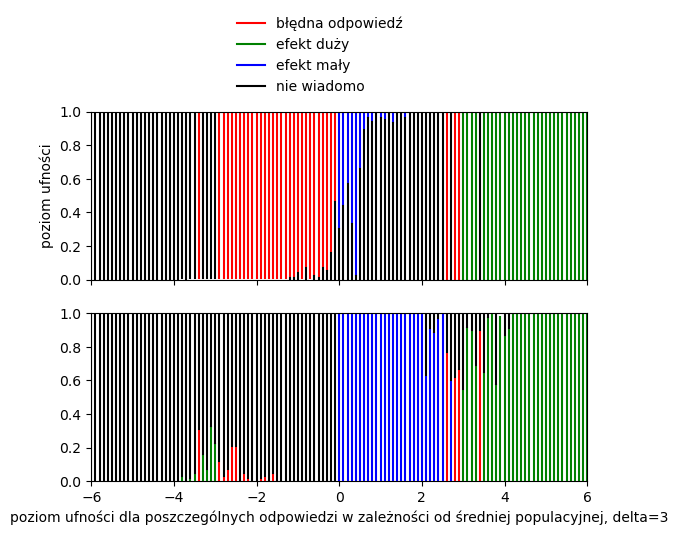

In [44]:
def rysuj():
    fig, (ax1,ax2) = plt.subplots(2,sharex=True)
    n1 = 50
    n2 = 50
    sd1 = 2
    sd2 = 2
    delta = 3
    mean1 = 0
    ax1.set_xlim(-6,6)
    diffs = [i*0.1 for i in range(-60,61)]
    for diff in diffs:
        if diff >= 0:
            delta = 3
        else:
            delta = -3
        sample1 = get_normal_sample(n1,mean1+diff,sd1)
        sample2 = get_normal_sample(n2,mean1,sd2)
        res2=[independent_2(sample1,sample2,i*0.01,delta) for i in range(1,101)]
        res3=[independent_3(sample1,sample2,i*0.01,delta) for i in range(1,101)]
        result = diff
        res2_vals = {'m':[1-(i+1)*0.01 for i,x in enumerate(res2) if x == 'm'],'d':[1-(i+1)*0.01 for i,x in enumerate(res2) if x == 'd'],'nwd':[1-(i+1)*0.01 for i,x in enumerate(res2) if x == 'nwd']}
        res3_vals = {'m':[1-(i+1)*0.01 for i,x in enumerate(res3) if x == 'm'],'d':[1-(i+1)*0.01 for i,x in enumerate(res3) if x == 'd'],'nwd':[1-(i+1)*0.01 for i,x in enumerate(res3) if x == 'nwd']}
        
        
        if np.abs(result) >= delta :
            if len(res2_vals['m']) != 0:
                ax1.axvline(diff,ymin=res2_vals['m'][-1],ymax=res2_vals['m'][0], color = 'red')
            if len(res2_vals['d']) != 0:
                ax1.axvline(diff,ymin=res2_vals['d'][-1],ymax=res2_vals['d'][0], color = 'green')#,label = 'efekt duży')
            if len(res2_vals['nwd']) != 0:
                ax1.axvline(diff,ymin=res2_vals['nwd'][-1],ymax=res2_vals['nwd'][0], color = 'black')#,label = 'nie wiadomo')            
            if len(res3_vals['m']) != 0:
                ax2.axvline(diff,ymin=res3_vals['m'][-1],ymax=res3_vals['m'][0], color = 'red')
            if len(res3_vals['d']) != 0:
                ax2.axvline(diff,ymin=res3_vals['d'][-1],ymax=res3_vals['d'][0], color = 'green')#,label = 'efekt duży')
            if len(res3_vals['nwd']) != 0:
                ax2.axvline(diff,ymin=res3_vals['nwd'][-1],ymax=res3_vals['nwd'][0], color = 'black')#,label = 'nie wiadomo')

        else:

            if len(res2_vals['m']) != 0:
                ax1.axvline(diff,ymin=res2_vals['m'][-1],ymax=res2_vals['m'][0], color = 'blue')#,label = 'efekt mały')
            if len(res2_vals['d']) != 0:
                ax1.axvline(diff,ymin=res2_vals['d'][-1],ymax=res2_vals['d'][0], color = 'red')
            if len(res2_vals['nwd']) != 0:
                ax1.axvline(diff,ymin=res2_vals['nwd'][-1],ymax=res2_vals['nwd'][0], color = 'black')#,label = 'nie wiadomo')            
            if len(res3_vals['m']) != 0:
                ax2.axvline(diff,ymin=res3_vals['m'][-1],ymax=res3_vals['m'][0], color = 'blue')#,label = 'efekt mały')
            if len(res3_vals['d']) != 0:
                ax2.axvline(diff,ymin=res3_vals['d'][-1],ymax=res3_vals['d'][0], color = 'red')
            if len(res3_vals['nwd']) != 0:
                ax2.axvline(diff,ymin=res3_vals['nwd'][-1],ymax=res3_vals['nwd'][0], color = 'black')#,label = 'nie wiadomo')
    
    ax1.axvline(0,ymin=0,ymax=0,color='red',label = 'błędna odpowiedź')
    ax1.axvline(0,ymin=0,ymax=0,color='green',label = 'efekt duży')
    ax1.axvline(0,ymin=0,ymax=0,color='blue',label = 'efekt mały')
    ax1.axvline(0,ymin=0,ymax=0,color='black',label = 'nie wiadomo')
    ax1.set_ylabel('poziom ufności')
    ax2.set_xlabel('poziom ufności dla poszczególnych odpowiedzi w zależności od średniej populacyjnej, delta=3')
    mlt.rcParams.update(mlt.rcParamsDefault)

    fig.legend(frameon=False, loc = 'center', bbox_to_anchor = (0.5,1))
        
        
%time rysuj()

In [89]:
dane = pd.read_csv('data.csv')
x1 = dane['x1']
x2 = dane['x2']
#np.mean(x1) - np.mean(x2)
t_test_for_independent_groups(x1,x2,diff=4,alternative='greater')

0.0002223307845566902